# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc
from scipy import stats
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# Load the data set
train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")


print(train_transaction.shape)

train_data = pd.merge(train_transaction, train_identity, on = "TransactionID", how = "outer")

del train_transaction, train_identity

(590540, 394)


In [4]:
pd.set_option("display.max_columns", None)
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [5]:
test_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")
test_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_identity.csv")
test_data = pd.merge(test_transaction, test_identity, on = "TransactionID", how = "outer")
del test_transaction, test_identity
test_data

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.0,150.0,v

In [6]:
test_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

In [7]:
# change column name of id in test data as it has "-""
test_data.columns = test_data.columns.str.replace("-","_")


In [8]:
#inofrmation of train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [9]:
#inofrmation of test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB


In [10]:
#statistical info
train_data.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [11]:
#statistical info
test_data.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,36436.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,501943.000000,506688.000000,500660.000000,271922.000000,303549.000000,429840.000000,282316.000000,124783.000000,60133.000000,74338.000000,74338.000000,494146.000000,330173.000000,69254.000000,123384.000000,115194.000000,494622.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.00000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.00000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.0,506691.000000,506691.000000,506691.

# Data Visualization

Charts of categorical variables to understand the unique counts hence I can make new features using this information

### Fraud distribution of train data. Check for balance data

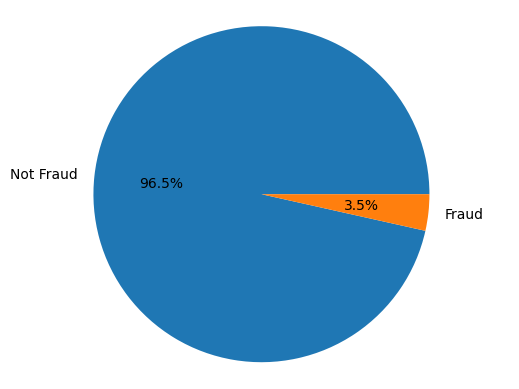

In [12]:
plt.pie(train_data['isFraud'].value_counts(), labels =["Not Fraud", "Fraud"], autopct = "%0.1f%%")
plt.axis('equal')
plt.show()

This is imbalance classification problem. Can apply SMOTE, Undersampling techniques

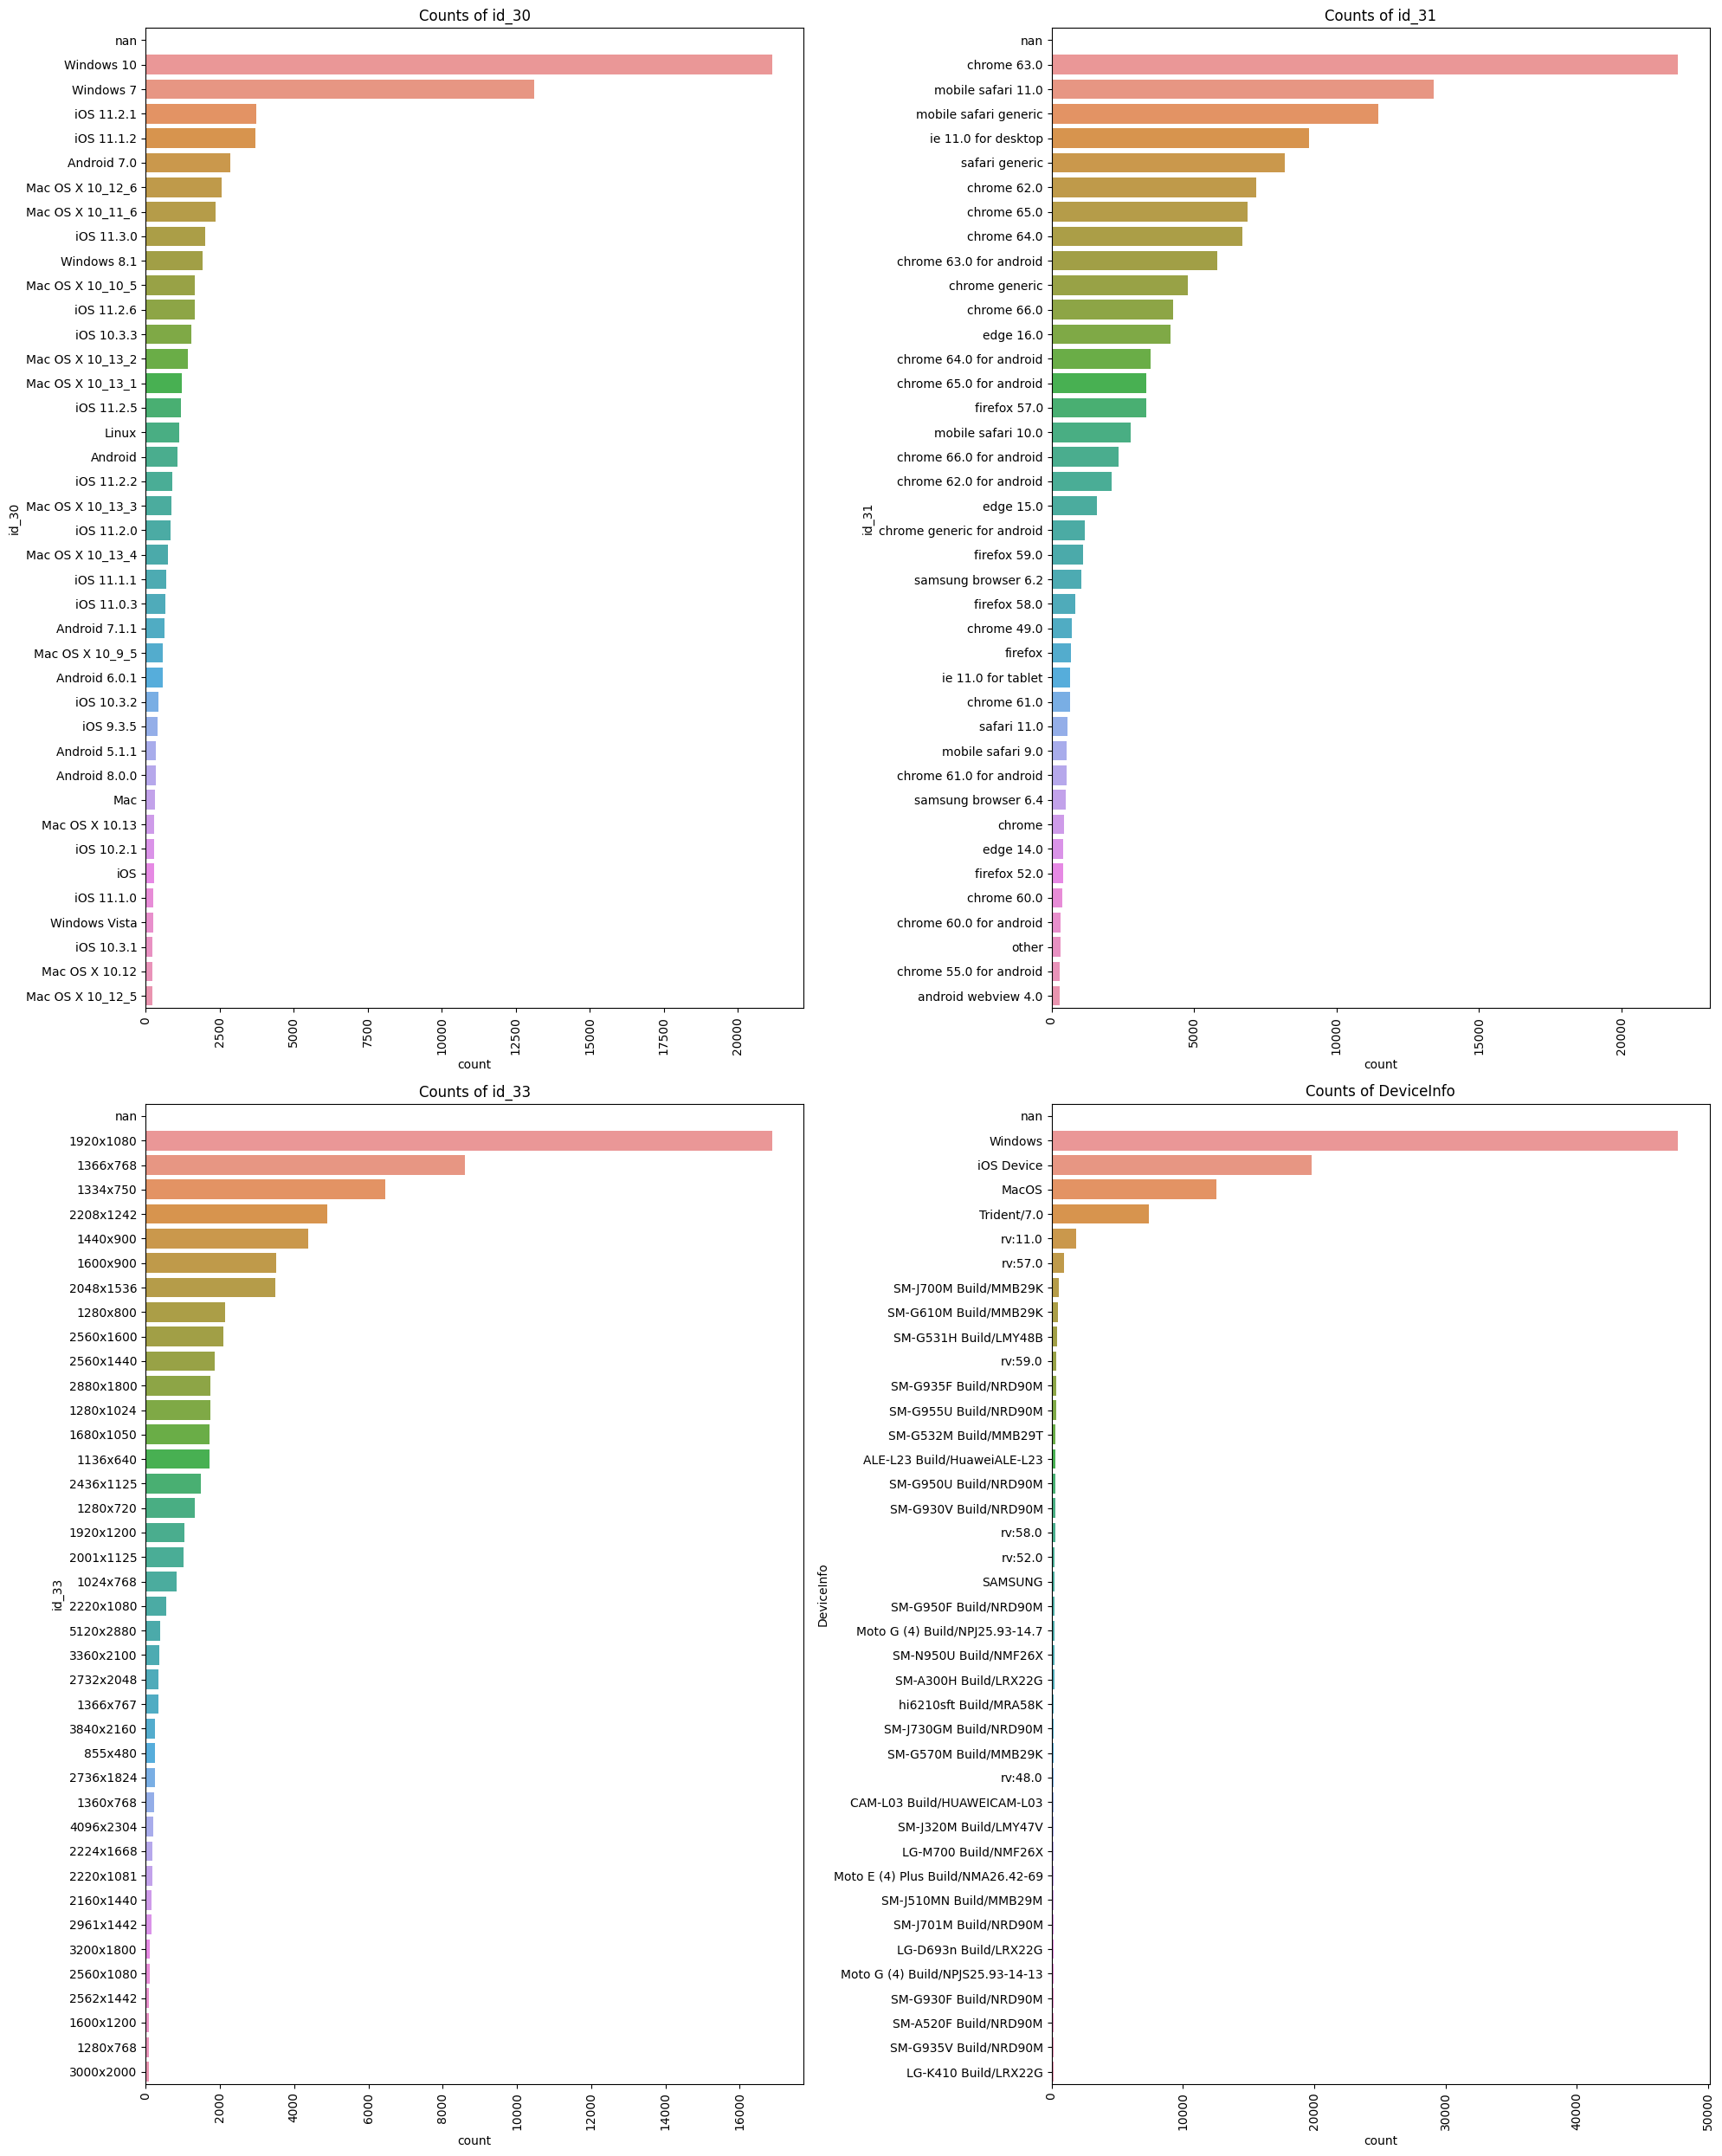

In [13]:
cols  =['id_30', 'id_31', 'id_33', 'DeviceInfo']
fig, axs = plt.subplots(2,2,figsize=(20,25))

axs = axs.flatten()

for i , feature in enumerate(cols):
    unique_vals = train_data[feature].nunique()  # Get the number of unique values
    
    sns.countplot(data=train_data, y=feature, ax=axs[i], 
                  order=train_data[feature].value_counts(dropna=False).iloc[:40].index )
    axs[i].set_title(f"Counts of {feature}")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)



# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

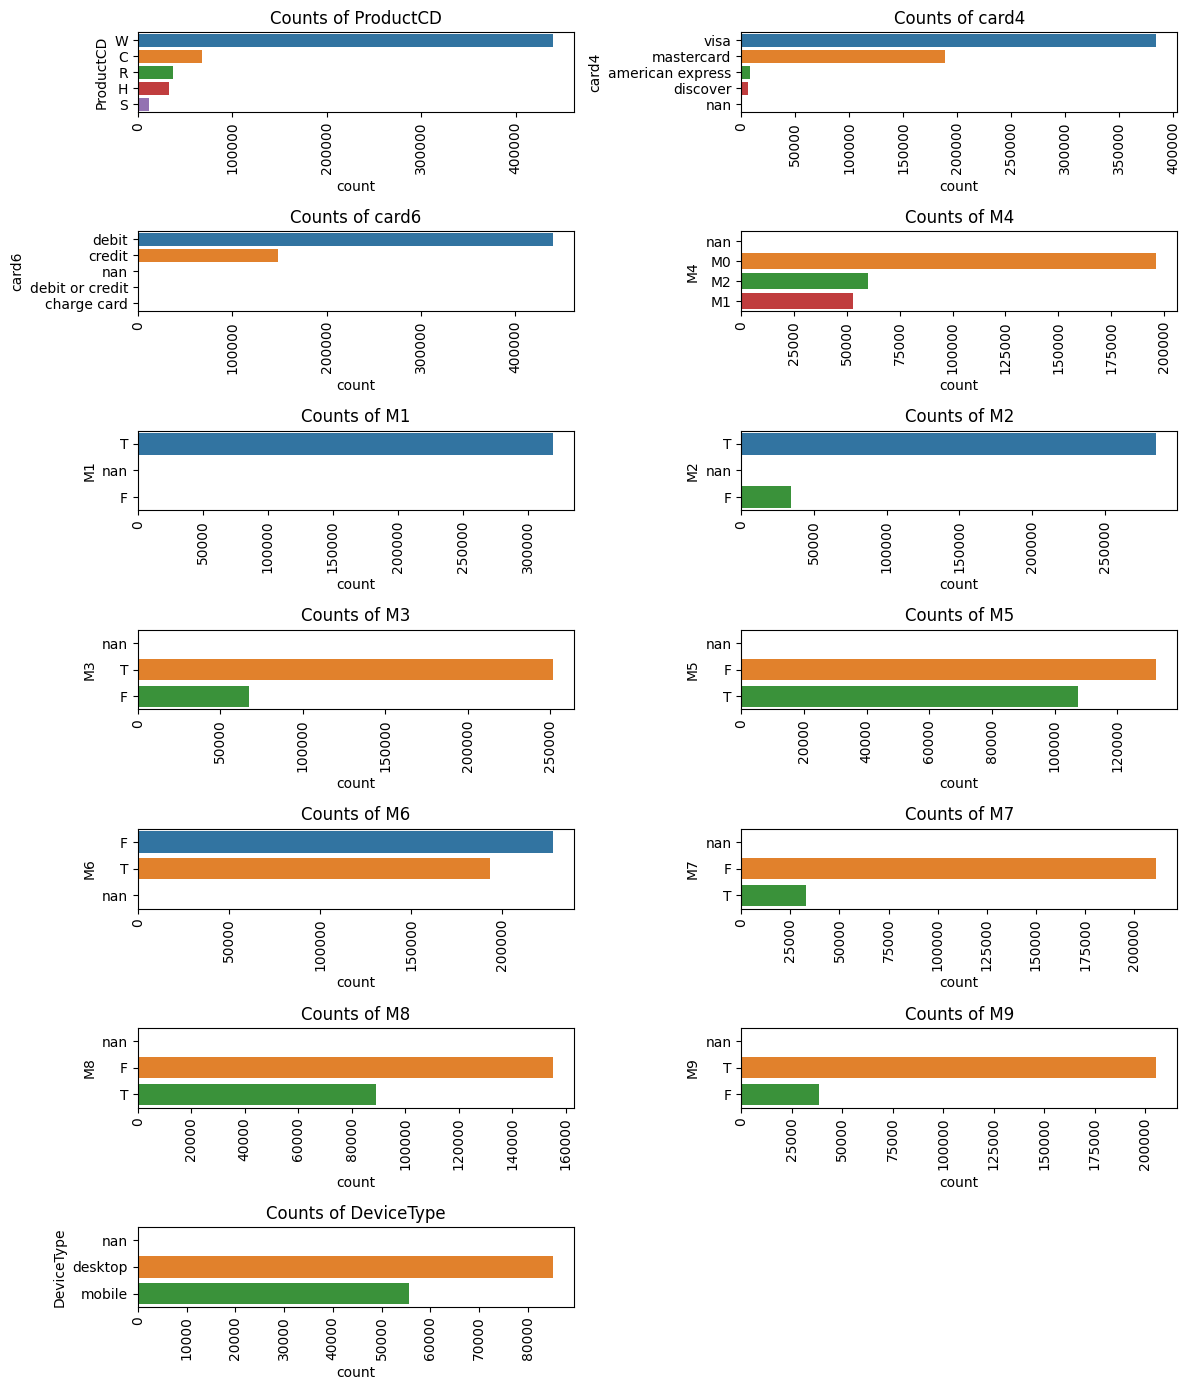

In [14]:
cols =['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9','DeviceType']
fig, axs = plt.subplots(7,2,figsize=(12,14))

axs = axs.flatten()

for i , feature in enumerate(cols):
    unique_vals = train_data[feature].nunique()  # Get the number of unique values
    
    sns.countplot(data=train_data, y=feature, ax=axs[i], 
                  order=train_data[feature].value_counts(dropna=False).iloc[:40].index )
    axs[i].set_title(f"Counts of {feature}")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Hide the last subplot if there are fewer plots than subplots
fig.delaxes(axs[-1])

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

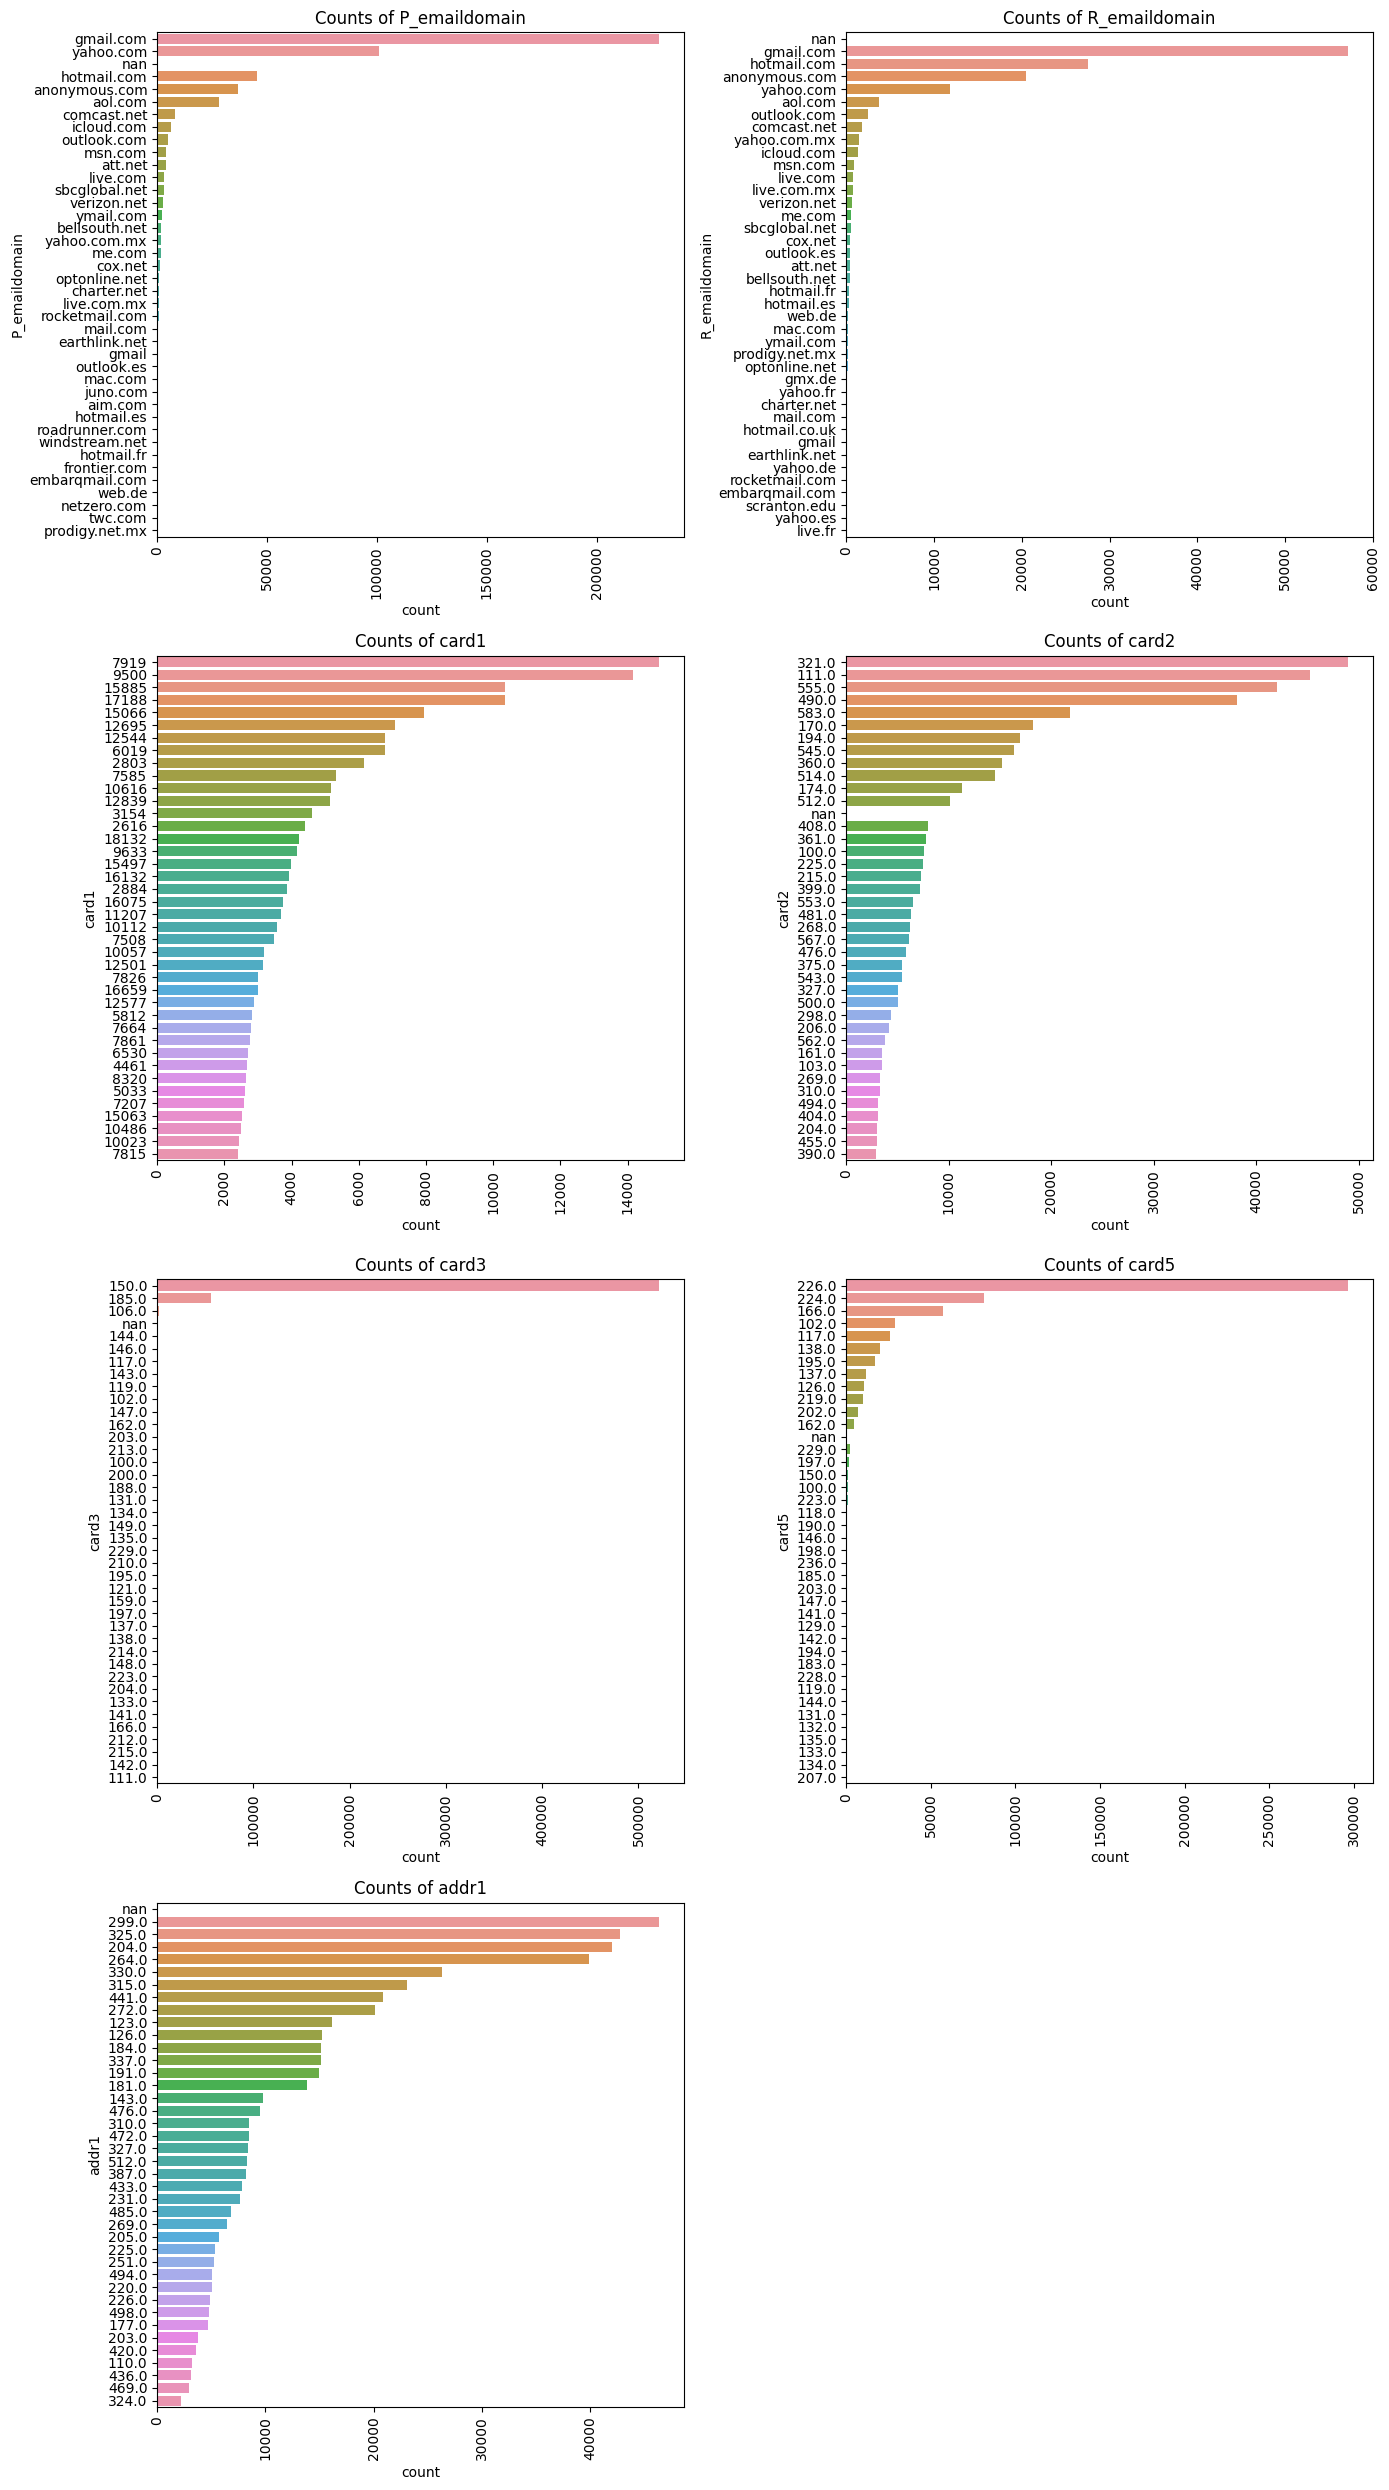

In [15]:
cols = ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']
fig, axs = plt.subplots(4,2,figsize=(14,25))

axs = axs.flatten()

for i , feature in enumerate(cols):
    unique_vals = train_data[feature].nunique()  # Get the number of unique values
    
    sns.countplot(data=train_data, y=feature, ax=axs[i], 
                  order=train_data[feature].value_counts(dropna=False).iloc[:40].index )
    axs[i].set_title(f"Counts of {feature}")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Hide the last subplot if there are fewer plots than subplots
fig.delaxes(axs[-1])

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

<Axes: xlabel='isFraud', ylabel='count'>

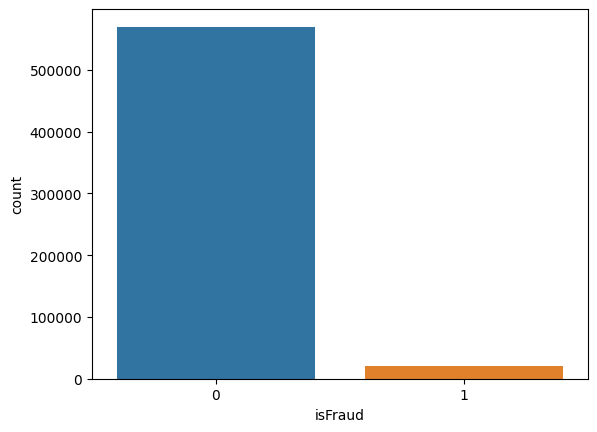

In [16]:
# Imbalance Data
sns.countplot(train_data, x='isFraud')

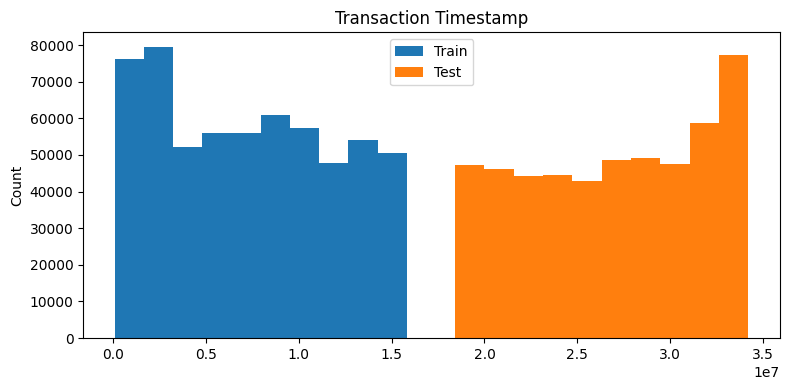

In [17]:
# Timestamp of trian and test data

plt.figure(figsize = (8,4))
plt.hist(train_data['TransactionDT'], label = 'Train')
plt.hist(test_data['TransactionDT'], label = "Test")
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
#missinf values

na_data = train_data.isna()
group_na = {}
v_col = ["V"+str(i) for i in range(1,340)]

for col in train_data.columns:
    col_group = na_data[col].sum()
    try:
        group_na[col_group].append(col)
    except:
        group_na[col_group] =[col]
    
del na_data; x= gc.collect()
for k ,v in group_na.items():
    print(f"####Nan counts = {k} ")
    print(v)
 

####Nan counts = 0 
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
####Nan counts = 8933 
['card2']
####Nan counts = 1565 
['card3']
####Nan counts = 1577 
['card4']
####Nan counts = 4259 
['card5']
####Nan counts = 1571 
['card6']
####Nan counts = 65706 
['addr1', 'addr2']
####Nan counts = 352271 
['dist1']
####Nan counts = 552913 
['dist2']
####Nan counts = 94456 
['P_emaildomain']
####Nan counts = 453249 
['R_emaildomain']
####Nan counts = 1269 
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
####Nan counts = 280797 
['D2']
####Nan counts = 262878 
['D3']
####Nan counts = 168922 
['D4']
####Nan counts = 309841 
['D5']
####Nan counts = 517353 
['D6']
####Nan counts = 551623 
['D7']
####Nan counts = 515614 
['D8', 'D9', 'id_09', 'id_10']
####Nan counts = 76022 
['D10']
####Nan counts = 279287 
['D11', 'V1', 'V2',

In [19]:
# #missinf values

# na_data = test_data.isna()
# group_na = {}
# v_col = ["V"+str(i) for i in range(1,340)]

# for col in test_data.columns:
#     col_group = na_data[col].sum()
#     try:
#         group_na[col_group].append(col)
#     except:
#         group_na[col_group] =[col]
    
# del na_data; x= gc.collect()
# for k ,v in group_na.items():
#     print(f"####Nan counts = {k} ")
#     print(v)

In [20]:
# apply memory usage function
train_data= reduce_mem_usage(train_data)


test_data = reduce_mem_usage(test_data)

Memory usage of dataframe is 1955.37 MB
Memory usage after optimization is: 525.55 MB
Decreased by 73.1%
Memory usage of dataframe is 1673.87 MB
Memory usage after optimization is: 458.20 MB
Decreased by 72.6%


In [21]:
del group_na
gc.collect()

0

# Remove outlier of using z-score

In [22]:
## Remove the outlier using z score

z_scores = stats.zscore(train_data['TransactionAmt'])
non_outlier = np.abs(z_scores)<=3
print(f"Number of Rows Before: {len(train_data)}")
train_data = train_data[non_outlier]
print(f"Number of Rows After: {len(train_data)}")

Number of Rows Before: 590540
Number of Rows After: 590540


In [23]:
z_scores = stats.zscore(test_data['TransactionAmt'])

non_outlier = np.abs(z_scores)<=3
print(f"Number of Rows Before: {len(test_data)}")
test_data = test_data[non_outlier]
print(f"Number of Rows After: {len(test_data)}")
del z_scores

Number of Rows Before: 506691
Number of Rows After: 506691


# Sort the columns

In [24]:
# Selecting numeric columns
train_num_cols = train_data.select_dtypes(include=['number']).columns.tolist()

# Selecting categorical columns (string, object types, etc.)
train_cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Print or check the lists
print("Numeric Columns: ", len(train_num_cols),train_num_cols)
print("\n\nCategorical Columns: ",len(train_cat_cols), train_cat_cols)
del train_num_cols, train_cat_cols

Numeric Columns:  403 ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', '

In [25]:
# # Selecting numeric columns
# test_num_cols = test_data.select_dtypes(include=['number']).columns.tolist()

# # Selecting categorical columns (string, object types, etc.)
# test_cat_cols = test_data.select_dtypes(include=['object']).columns.tolist()

# # Print or check the lists
# print("Numeric Columns: ", len(test_num_cols),test_num_cols)
# print("\n\nCategorical Columns: ", len(test_cat_cols),test_cat_cols)


In [26]:
# list of column use for the final data set
required_col =  ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt','ProductCD', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
                 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 
                 'D3', 'D4', 'D5', 'D6', 'D7', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1',  'V3', 'V4', 'V6', 
                 'V8', 'V11',  'V13', 'V14',  'V17',  'V20', 'V23','V26', 'V27','V30',  'V36', 'V37',  'V40', 'V41',  
                 'V44','V47', 'V48','V54','V56','V59','V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 
                 'V80','V82','V86','V88', 'V89','V91', 'V96','V98', 'V99','V104','V107', 'V108', 'V111',
                 'V115','V117','V120', 'V121','V123', 'V124', 'V127','V129', 'V130','V136', 'V138', 'V139','V142',
                 'V147', 'V156','V160','V162','V165', 'V166', 'V173','V176','V178','V182','V187', 'V203',
                 'V205', 'V207','V215','V218','V223', 'V224','V226','V228', 'V229', 'V235', 'V240', 
                 'V258', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V284', 'V285', 'V286',
                 'V291','V294', 'V297','V303', 'V305', 'V307','V309', 'V320', 
                 'card4', 'card6','P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
                 'M8', 'M9', 'id_12', 'id_15', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
                 'DeviceType', 'DeviceInfo']


print("Original number of column in data:", len(train_data.columns))
print("After sorting the columns:",len(required_col))

Original number of column in data: 434
After sorting the columns: 166


In [27]:
# delete other column  from data
# train_data = train_data[required_col]
# test_data= test_data[[col for col in required_col if col != 'isFraud']]

train_data=train_data[[col for col in train_data.columns if col  in required_col]]
test_data=test_data[[col for col in test_data.columns if col  in required_col]]
del required_col

# Feature Engineering

In [28]:

#TRAIN
# id_30 has the os information with version I will just take the name of os
train_data['os'] = train_data['id_30'].str.split(' ', expand=True)[0]

# seprate the domain of email 
train_data[['P_emailserver', 'P_suffix']] = train_data['P_emaildomain'].str.split('.', n=1, expand=True)
train_data[['R_emailserver', 'R_suffix']] = train_data['R_emaildomain'].str.split('.', n=1, expand=True)

train_data['browser'] = train_data['id_31'].str.split(' ', expand=True)[0].str.lower()
train_data['device_name'] = train_data['DeviceInfo'].str.split(' ', expand=True)[0].str.lower()


##########################
#TEST
test_data['os']  = test_data['id_30'].str.split(' ', expand=True)[0]
test_data[['P_emailserver', 'P_suffix']] = test_data['P_emaildomain'].str.split('.', n=1, expand=True)
test_data[['R_emailserver', 'R_suffix']] = test_data['R_emaildomain'].str.split('.', n=1, expand=True)
test_data['browser'] = test_data['id_31'].str.split(' ', expand=True)[0].str.lower()
test_data['device_name'] = test_data['DeviceInfo'].str.split(' ', expand=True)[0].str.lower()




gc.collect()

22

# Understanding the date time of the data
https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

 TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

In [29]:
# print("Minimum value is: ", train_data['TransactionDT'].min())
# print("Maximum value is: ", train_data['TransactionDT'].max())
# # 1 minute = 60 seconds
# # 1 hour = 60 minutes
# # 1 day = 24 hours

# print("Seconds per day: ")
# print(60 * 60 * 24)

# print('\nSeconds for 6 months:')
# print(60 * 60 * 24 *183)

# print("\n Conclusion: this data contains 6 months information.")

# print("Minimum value is: ", test_data['TransactionDT'].min())
# print("Maximum value is: ", test_data['TransactionDT'].max())

In [30]:
# Convert TransactionDT into Days and hours
start_time_train = train_data['TransactionDT'].min()
train_data['TransactionDT_days']  = (train_data['TransactionDT'] -  start_time_train) // (60*60*24)
train_data['TransactionDT_hours'] = (train_data['TransactionDT'] - start_time_train) // (60* 60) %24


start_time_test = test_data['TransactionDT'].min()
test_data['TransactionDT_days']  = (test_data['TransactionDT'] -  start_time_test) // (60*60*24)
test_data['TransactionDT_hours'] = (test_data['TransactionDT'] - start_time_test) // (60* 60) %24


In [31]:
drop_col =['id_30','P_emaildomain','R_emaildomain','id_31','DeviceInfo', 'TransactionDT']
# drop the above columns
train_data.drop(columns= drop_col,axis= 1, inplace=True)
test_data.drop(columns=drop_col,axis =1,  inplace=True)

# Imputation

If some columns contain Inf (infinity) or other invalid values that are not recognized as missing values (NaN), they won't be imputed. Check if any of the columns contain Inf or invalid entries.

In [32]:
#  Hidden NaN Values in Other Formats

# Replace common placeholder strings with NaN
missing_formats = ["", "None", "NaN", "N/A", "null", "?"]
train_data.replace(missing_formats, np.nan, inplace=True)
test_data.replace(missing_formats, np.nan, inplace=True)



In [33]:
# TRAIN
train_num_cols = train_data.select_dtypes(include= ['number']).columns.tolist()
train_cat_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
# len(train_cat_cols), train_cat_cols 

# TEST
test_num_cols = test_data.select_dtypes(include= ['number']).columns.tolist()
test_cat_cols = test_data.select_dtypes(include=['object', 'category']).columns.tolist()
# len(test_num_cols), test_num_cols 

In [34]:
# for col in train_cat_cols:
#     if train_data[col].isnull().all():
#         train_data[col]='Unknown'
#     else:
#         train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
        
        
# for col in test_cat_cols:
#     if test_data[col].isnull().all():
#         test_data[col] = 'Unknown'
#     else:
#         test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

In [35]:
# for col in train_num_cols:
#     if train_data[col].isnull().all():
#         train_data[col] = 0  # or another default value

# for col in test_num_cols:
#     if test_data[col].isnull().all():
#         test_data[col] = 0


In [36]:
print(train_data.isnull().sum())  # Print number of NaNs per column
print(test_data.isnull().sum())   # Print number of NaNs per column


TransactionID               0
isFraud                     0
TransactionAmt              0
ProductCD                   0
card1                       0
                        ...  
R_suffix               453344
browser                450258
device_name            471874
TransactionDT_days          0
TransactionDT_hours         0
Length: 169, dtype: int64
TransactionID               0
TransactionAmt              0
ProductCD                   0
card1                       0
card2                    8654
                        ...  
R_suffix               370922
browser                370066
device_name            391634
TransactionDT_days          0
TransactionDT_hours         0
Length: 168, dtype: int64


In [37]:
# Impute missing values

# Fill missing values in numerical columns (you can use median/mean depending on your choice)
train_data[train_num_cols] = train_data[train_num_cols].fillna(train_data[train_num_cols].median())
test_data[test_num_cols] = test_data[test_num_cols].fillna(test_data[test_num_cols].median())

# Fill missing values in categorical columns with the mode (most frequent value)
for col in train_cat_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

for col in test_cat_cols:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Checking for any remaining NaN values
print(train_data.isnull().sum().sum())  # Should print 0 if all NaN values are filled
print(test_data.isnull().sum().sum())  # Should print 0 if all NaN values are filled
gc.collect()

0
0


287

In [38]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_columns", None)
train_data

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,V23,V26,V27,V30,V36,V37,V40,V41,V44,V47,V48,V54,V56,V59,V62,V65,V67,V68,V70,V76,V78,V80,V82,V86,V88,V89,V91,V96,V98,V99,V104,V107,V108,V111,V115,V117,V120,V121,V123,V124,V127,V129,V130,V136,V138,V139,V142,V147,V156,V160,V162,V165,V166,V173,V176,V178,V182,V187,V203,V205,V207,V215,V218,V223,V224,V226,V228,V229,V235,V240,V258,V260,V261,V264,V266,V267,V274,V277,V284,V285,V286,V291,V294,V297,V303,V305,V307,V309,V320,id_12,id_15,id_23,id_27,id_28,id_29,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,os,P_emailserver,P_suffix,R_emailserver,R_suffix,browser,device_name,TransactionDT_days,TransactionDT_hours
0,2987000,0,68.500000,W,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,F,F,T,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117.000000,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,117.000000,0.0,0.000000,NotFound,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,desktop,Windows,gmail,com,gmail,com,chrome,windows,0,0
1,2987001,0,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,T,T,T,M0,T,T,F,F,T,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,NotFound,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,desktop,Windows,gmail,com,gmail,com,chrome,windows,0,0
2,2987002,0,59.000000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,0.0,315.0,0.0,0.0,0.0,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,NotFound,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,desktop,Windows,outlook,com,gmail,com,chrome,windows,0,0
3,2987003,0,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,0.0,84.0,43.0,0.0,0.0,0.0,111.0,T,T,T,M0,T,F,F,F,T,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,48.0,0.0,10.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1758.000000,0.0,354.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,38.0,0.0,0.0,1.0,1758.000000,0.0,0.000000,NotFound,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,desktop,Windows,yahoo,com,gmail,com,chrome,windows,0,0
4,2987004,0,50.000000,H,4497,514

In [39]:
# print(len(train_cat_cols), train_cat_cols )
# print(len(train_num_cols), train_num_cols )

# One Hot Encoding
Will apply the one hot encoding only to those columns which has atleast 5 unique values, to others will apply label encoder to avoid multple columns


In [40]:
oh_cols =  ['ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'DeviceType']

# train_data[oh_cols] = train_data[oh_cols].fillna('missing')
# test_data[oh_cols] = test_data[oh_cols].fillna('missing')


In [41]:
oh_cols =  ['ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'DeviceType']

encoder = OneHotEncoder(sparse= False, handle_unknown ='ignore')

# apply one hot encoding to selected cat columns
train_encoded_cat = encoder.fit_transform(train_data[oh_cols])
test_encoded_cat = encoder.transform(test_data[oh_cols])

#convert matrix into the dataframe
train_encoded_df = pd.DataFrame(train_encoded_cat, columns= encoder.get_feature_names_out(oh_cols), index=train_data.index)
test_encoded_df = pd.DataFrame(test_encoded_cat, columns = encoder.get_feature_names_out(oh_cols),index=test_data.index)

#merge df into the train and test
train_data = pd.concat([train_data, train_encoded_df], axis=1)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

# drop the original columns
train_data.drop(columns=oh_cols, inplace=True)
test_data.drop(columns=oh_cols, inplace=True)

In [42]:

pd.set_option("display.max_columns", None)
train_data

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D10,D11,D12,D13,D14,D15,V1,V3,V4,V6,V8,V11,V13,V14,V17,V20,V23,V26,V27,V30,V36,V37,V40,V41,V44,V47,V48,V54,V56,V59,V62,V65,V67,V68,V70,V76,V78,V80,V82,V86,V88,V89,V91,V96,V98,V99,V104,V107,V108,V111,V115,V117,V120,V121,V123,V124,V127,V129,V130,V136,V138,V139,V142,V147,V156,V160,V162,V165,V166,V173,V176,V178,V182,V187,V203,V205,V207,V215,V218,V223,V224,V226,V228,V229,V235,V240,V258,V260,V261,V264,V266,V267,V274,V277,V284,V285,V286,V291,V294,V297,V303,V305,V307,V309,V320,id_15,id_23,id_27,id_28,id_29,id_33,id_34,id_35,id_36,id_37,id_38,os,P_emailserver,P_suffix,R_emailserver,R_suffix,browser,device_name,TransactionDT_days,TransactionDT_hours,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M1_F,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T,id_12_Found,id_12_NotFound,DeviceType_desktop,DeviceType_mobile
0,2987000,0,68.500000,13926,361.0,150.0,142.0,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,0.0,13.0,13.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117.000000,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,117.000000,0.0,0.000000,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,Windows,gmail,com,gmail,com,chrome,windows,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2987001,0,29.000000,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,Windows,gmail,com,gmail,com,chrome,windows,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,2987002,0,59.000000,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,0.0,0.0,315.0,0.0,0.0,0.0,315.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0000,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,1920x1080,match_status:2,T,F,T,F,Windows,outlook,com,gmail,com,chrome,windows,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,2987003,0,50.000000,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,0.0,84.0,43.0,0.0,0.0,0.0,111.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,

In [43]:
encoder.get_feature_names_out()

array(['ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'card6_charge card',
       'card6_credit', 'card6_debit', 'card6_debit or credit', 'M1_F',
       'M1_T', 'M2_F', 'M2_T', 'M3_F', 'M3_T', 'M4_M0', 'M4_M1', 'M4_M2',
       'M5_F', 'M5_T', 'M6_F', 'M6_T', 'M7_F', 'M7_T', 'M8_F', 'M8_T',
       'M9_F', 'M9_T', 'id_12_Found', 'id_12_NotFound',
       'DeviceType_desktop', 'DeviceType_mobile'], dtype=object)

# LabelEncoder


In [44]:
# get the columns for LabelEncoder

train_label_cat_col = [col for col in train_cat_cols if col not in oh_cols ]
test_label_cat_col = [col for col in test_cat_cols if col not in oh_cols ]

#TRAIN
for col in train_label_cat_col:
    encoder = LabelEncoder()
    train_data[col] = encoder.fit_transform(train_data[col])
    
#TEST
for col in test_label_cat_col:
    encoder = LabelEncoder()
    test_data[col] = encoder.fit_transform(test_data[col])


In [45]:
train_data.to_csv("train_fraud_detection_cleaned_data.csv", index=False)
test_data.to_csv("test_fraud_detection_cleaned_data.csv", index=False)

In [46]:
pd.set_option("display.max_columns", None)
print(train_data.shape)
print(test_data.shape)


(590540, 191)
(506691, 190)
